# Climatology

# Présentation
La méthode climato de lntime permet à partir d'un dataset :
 - d'effectuer une régression d'un signal :
     - sur des cycles annuels ou semi-annuels
     - sur des polynomes d'ordre quelconque
     - sur n'importe quelle fonction paramétrée par l'utilisateur
 - de calculer le signal climatique ou les résidus par rapports aux fonctions choisies :
     - aux instants du signal d'entrée
     - a d'autres instants en interpolant les résidus avec un filtre au choix
     - les résidus des valeurs Nan sont interpolés avec un filtre au choix

L'échantillonnage temporel peut être quelconque.

Basiquement, la climato résoud un moindre carrés Y = A.X, où Y est un signal dépendant du temps, et X une matrice de fonctions temporelles définies (cycle annuel, moyenne, tendance, accélération, fonction quelconque, etc...). A contient donc les coefficients à appliquer à chacune de ces fonctions temporelles pour minimiser les résidus Y - A.X

Format du dataset en entrée :
 - une dimension doit correspondre à la temporalité. La variable temporelle n'est pas nécessairement en coordonnée, elle peut être une variable du dataset
 - Il peut y avoir un nombre quelconque de dimensions indépendantes du temps (latitude, longitude, profondeur, modèles, etc...)

# Initialisation
*climato(ds, dim='time', var=None, Nmin=6, cycle=True, order=1) :*
- ds : dataset contenant les données
- dim :nom de la dimension sur laquelle faire les régressions
- var : nom de la variable ou coordonnée contenant les informations temporelles. Si None, var=dim
- Nmin : nombre minimum de données valides pour calculer les coefficients. Ce nombre est à ajouter au nombre des fonctions de régression. Si Nmin=0 et qu'on calcule les cycles annuels, semi-annuels, la tendance et la moyenne, il faut au moins 6 points valides pour avoir un résultat, sinon les coefficients sont tous renseignés avec NaN.
- cycle : utilisation par défaut des fonctions de cycles annuels et semi-annuels
- order : ordre du polynome sur lequel faire la régression. Si order=-1, pas de régression polynomiale

# Ajout de fonctions personnalisées :
*c.add_coeffs(func, coefficients, ref=None, scale=pd.to_timedelta("1D").asm8) :*
- func : fonction prenant en entrée une timeserie, et retournant un dataarray
- coefficients : nom des coefficients correspondant aà la sortie de la fonction func
- ref : origine temporelle pour le calcul de la fonction func
- scale : mise à l'échelle du temps pour le calcul de la fonction func
La fonction calculée est en fait func((x-ref)/scale)

# Calcul des coefficients :
*c.solve(mesure, chunk=None, poids=None, t_min=None, t_max=None) :*
- mesure : nom de la variable du dataset ds en entrée de la classe dont on veut calculer la climatologie
- chunk : si les données d'entrée sont volumineuses avec plusieurs dimensions, permet de paralléliser les calculs
- poids : matrice de poids à appliquer aux données d'entrée pour la moindre carré. Si poids=None, toutes les mesures ont le même poids
- t_min,t_max : début et fin de la période sur laquelle calculer la climato. Si None, pas de début ou pas de fin.

# Sorties
*c.climatology(coefficients=None, x=None) :*
Fonction climatique régressée
- coefficients : noms des coefficients à inclure dans la timeserie en sortie. Si coefficients=None, on les prend tous en compte
- x : instants de calcul. Si x=None, on utilise les temps du dataset en entrée : x=ds.var

*c.residuals(coefficients=None) :*
Résidus entre les mesures et la fonction climatique régressée
- coefficients : noms des coefficients à considérer pour le calcul des résidus. Si coefficients=None, on les prend tous en compte

*c.signal(x=None, coefficients=None, method='linear') :*
Signal incuant les résidus interpolés et la fonction climatique régressée. Si les résidus contiennent des NaN, ils sont interpolés avec la méthode choisie
- x :instants de calculs. Si x=None, on utilise les temps du dataset en entrée : x=ds.var
- coefficients : noms des coefficients à prendre en compte. Si coefficients=None, on les prend tous en compte
- method : filtre d'interpolation aux instants de calculs et pour les valeurs NaN. Parmi ceux de la méthode scipy.interp1d


In [1]:
import lenapy
import xarray as xr
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lenapy.constants import *


# Exemple sur une série temporelle simple

<xarray.Dataset> Size: 2MB
Dimensions:    (time: 216, latitude: 30, longitude: 30)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2005-01-14T23:46:17.343750 ... 2022-...
  * latitude   (latitude) float64 240B 30.5 31.5 32.5 33.5 ... 57.5 58.5 59.5
  * longitude  (longitude) float64 240B -29.5 -28.5 -27.5 ... -2.5 -1.5 -0.5
Data variables:
    ohc        (time, latitude, longitude) float64 2MB ...
    gohc       (time) float64 2kB ...

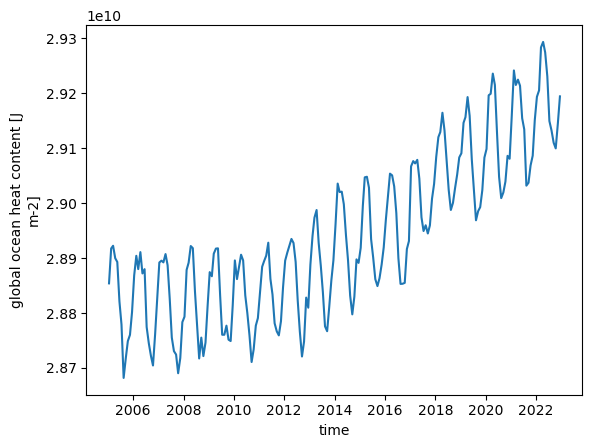

In [2]:
moheacan=xr.open_dataset('../../data/ohc.nc')
moheacan.gohc.plot()
moheacan

# Appel à la classe Climato
Par défaut, les fonctions de régression sont le cycle annuel, le cycle semi-annuel, la moyenne et la tendance

In [29]:
clim=moheacan.lntime.Climato()
clim.coeff_names

['cosAnnual',
 'sinAnnual',
 'cosSemiAnnual',
 'sinSemiAnnual',
 'order_0',
 'order_1']

# Calcul des coefficients de la climatologie sur une variable du dataset

Dans un premier temps, il faut calculer la climatologie en précisant la variable du dataset d'entrée contenant les mesures

In [30]:
clim.solve('gohc')

# Calcul du signal climatique correspondant

La méthode "climatology" retourne les différentes composantes du signal climatique. Si rien n'est précisé, la somme de toutes les composantes est calculées. Sinon, le paramètre "coefficients" contient une liste des noms des coefficients à retourner.
On peut calculer le signal climatique à des instants différents de ceux du signal d'origine, pour cela il faut passer dans l'argument x un dataset ou dataarray contenant toutes les variables nécessaires au calcul des fonctions à fitter. Généralement, 'time' suffit.

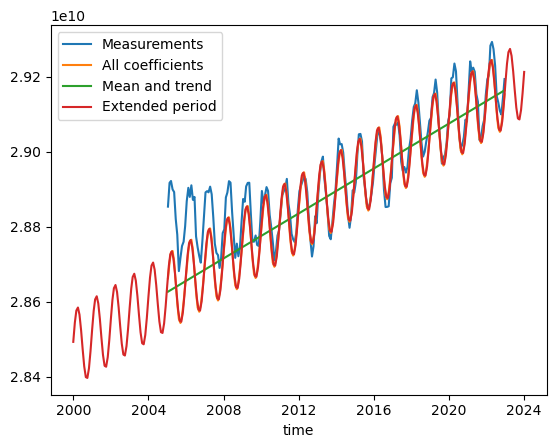

In [35]:
moheacan.gohc.plot(label='Measurements')
clim.climatology().plot(label='All coefficients')
clim.climatology(coefficients=['order_0','order_1']).plot(label='Mean and trend')
t_new=xr.DataArray(pd.date_range('2000','2024',freq='1MS'),dims=['time'])
clim.climatology(x=t_new,coefficients=['order_0','order_1','cosAnnual','sinAnnual']).plot(label='Extended period')

plt.legend()

La climatologie peut être calculée sur une période restreinte en utilisant les paramètres t_min et t_max

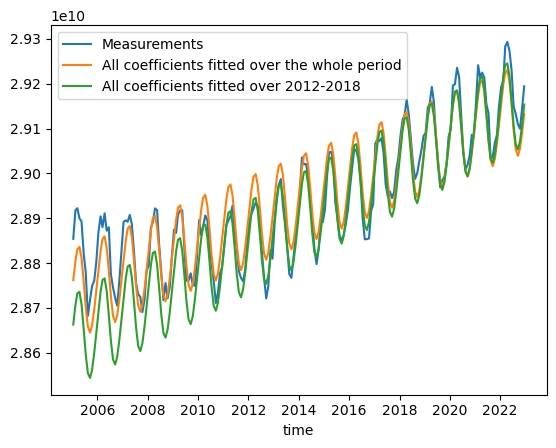

In [36]:
moheacan.gohc.plot(label='Measurements')
clim.solve('gohc').climatology().plot(label='All coefficients fitted over the whole period')
clim.solve('gohc',t_min='2012',t_max='2018').climatology().plot(label='All coefficients fitted over 2012-2018')

plt.legend()

Les fonctions à fitter sont appelées an appliquant une référence et une mise à l'échelle aux données d'entrées : *func((t-tref)/scale)*

Les fonctions de cycles annuels et semi-annuels, de moyenne et de tendance utilisées par défaut lors de l'instanciation de la classe Climato utilisent comme référence la première date de la série temporelle, et une mise à l'échelle pour avoir un jour comme unité de temps.

Pour utiliser d'autres références ou mises à l'échelle, ou d'autres fonctions à fitter, il faut spécifier à l'instanciation de la classe les fonctions par défaut qu'on ne veut pas (*cycle* ou *order*), puis ajouter manuellement les fonctions à fitter.  
Pour ajouter une fonction, deux possibilités :
- Avec une des deux fonctions instanciées dans la classe Climato :
  - *poly(oder,ref,scale)* : instancie une fonction polynomiale d'ordre au choix, avec possibilité de choisir la référence et la mise à l'échelle
  - *cycle(ref)* : cycles annuels et semi-annuels, avec possibilité de choisir la référence  
- Avec la méthode "add_coeffs" en définissant entièrement une fonction :
  - Il faut d'abord définir une fonction de une ou plusieurs variables, retournant un dataArray ayant deux dimensions :
    - une dimension égale à celle du dataset sur laquelle est calculée la climato (le plus souvent : 'time'), 
    - une autre appelée 'coeffs' permettant de retourner plusieurs fonctions à fitter en un seul appel    
  Cette fonction est de la forme *func(p1,p2,p3,...)*, et sera appelée ainsi *func((p1-ref)/scale, p2,p3,...)
  - Il faut attribuer cette fonction à l'instance de Climato avec la méthode *add_coeffs(coefficients,func,*args,ref,scale) :
    - *coefficients* contient les noms des composants de la fonction à fitter (*sinAnnual* ,*trend*, *acc*, ... au choix)
    - *func* est la fonction définie précédemment
    - **args* : le ou les noms des variables du dataset qui sont les paramètres de la fonctions (le plus souvent, *time*, mais ça peut être n'importe quelle autre variable)
    - *ref* et *scale* : référence et mise à l'échelle, **qui ne s'applique que sur le premier argument passé à la fonction**. Par défaut, ref est la valeur minimale de la variable, et scale=pd.to_timedelta("1D").asm8 (1 jour)

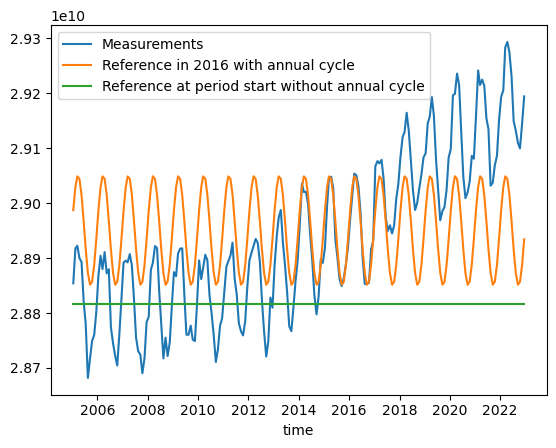

In [37]:
moheacan.gohc.plot(label='Measurements')

clim=moheacan.lntime.Climato(cycle=True,order=-1)
clim.poly(ref=pd.to_datetime('2016').asm8)
clim.solve('gohc')
clim.climatology(coefficients=['order_0','cosAnnual','sinAnnual']).plot(label='Reference in 2016 with annual cycle')

clim=moheacan.lntime.Climato(cycle=False,order=-1)
clim.poly()
clim.solve('gohc')
clim.climatology(coefficients=['order_0']).plot(label='Reference at period start without annual cycle')

plt.legend()

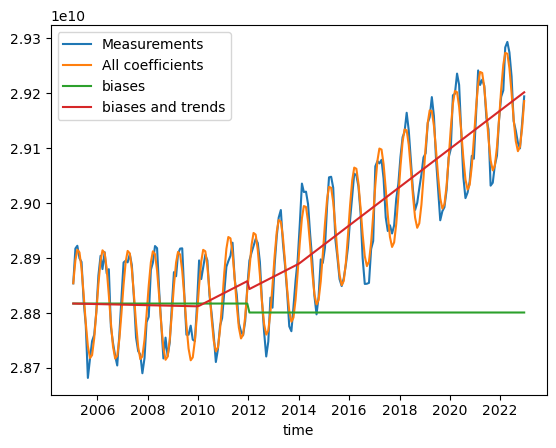

In [38]:
# Exemple des fonctions implémentées par défaut :
omega=2*np.pi/LNPY_DAYS_YEAR

def annual(x):
    return xr.concat((np.cos(omega*x),np.sin(omega*x)),dim="coeffs")

def semiannual(x):
    return xr.concat((np.cos(2*omega*x),np.sin(2*omega*x)),dim="coeffs")

def pol(x):
    return  x**xr.DataArray(np.arange(2),dims='coeffs')

# Exemple de fonction permettant de rajouter une deuxième tendance et un biais à partir d'une date:
def trend(x):
    return xr.where(x<0,0,x)

def bias(x):
    return xr.where(x<0,0,1.)
    
# Ajout des fonctions à fitter à l'instance Climato
clim=moheacan.lntime.Climato(cycle=False,order=-1)
# Cycle annuel
clim.add_coeffs(['cosAnnual','sinAnnual'],annual,'time')
# Biais et tendance
clim.add_coeffs(['bias1','trend1'],pol,'time')
# Deuxième biais à partir de 2012
clim.add_coeffs('bias2',bias,'time',ref=pd.to_datetime('2012').asm8)
# Deuxième tendance à partir de 2010
clim.add_coeffs('trend2',trend,'time',ref=pd.to_datetime('2010').asm8)
# Troisième tendance à partir de 2014 (utilisation de la même fonction)
clim.add_coeffs('trend3',trend,'time',ref=pd.to_datetime('2014').asm8)

clim.solve('gohc')
moheacan.gohc.plot(label='Measurements')
clim.climatology().plot(label='All coefficients')
clim.climatology(['bias1','bias2']).plot(label='biases')
clim.climatology(['bias1','bias2','trend1','trend2','trend3']).plot(label='biases and trends')
plt.legend()

# Calcul des residus

La méthode *residuals* retourne les résidus du signal en entrée par rapport au signal climatique. On peut choisir quels coefficients on intègre dans le signal climatique

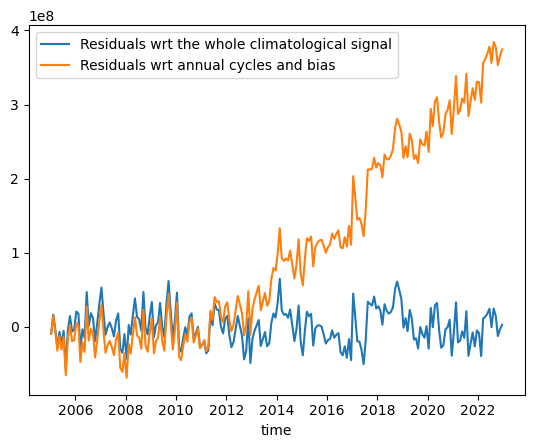

In [39]:
clim=moheacan.lntime.Climato(order=3)
clim.solve('gohc')
clim.residuals().plot(label='Residuals wrt the whole climatological signal')
clim.residuals(coefficients=['sinAnnual','cosAnnual','sinSemiAnnual','cosSemiAnnual','order_0']).plot(label='Residuals wrt annual cycles and bias')
plt.legend()

# Generation d'un signal et interpolation

La méthode *signal* permet de générer le signal d'origine :
- intégrant les coefficients du signal climatique que l'on souhaite
- interpolant les valeurs NaN du résidu du signal d'origine avec une méthode d'interpolation existant dans scipy.interp1d
- interpolé à d'autres dates que celle du signal d'origine (pas d'extrapolation possible)  
(Cette dernière fonctionnalité d'interpolation ne fonctionne pas si les fonctions climatiques prennent un autre argument que le temps en entrée, car cela supposerait une interpolation multi-dimensionnelle qui sort du cadre de cette classe)

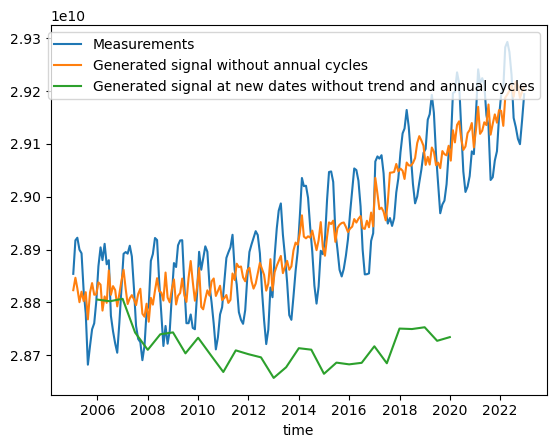

In [40]:
moheacan.gohc.plot(label='Measurements')

clim=moheacan.lntime.Climato(order=1)
clim.solve('gohc')
clim.signal(coefficients=['order_0','order_1']).plot(label='Generated signal without annual cycles')
t_new=xr.DataArray(pd.date_range('2006','2020',freq='6MS'),dims='time')
clim.signal(x=t_new,coefficients=['order_0']).plot(label='Generated signal at new dates without trend and annual cycles')
plt.legend()

Exemple d'interpolation en mettant à NaN deux années de mesure. 

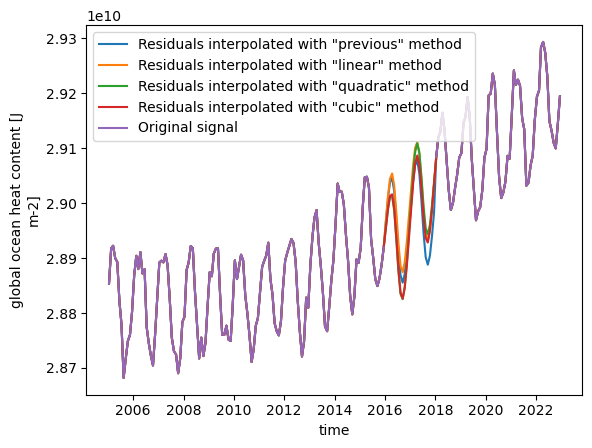

In [41]:
trous=moheacan.where((moheacan.time<pd.to_datetime('2016'))|(moheacan.time>pd.to_datetime('2018')))
clim=trous.lntime.Climato(order=2)
clim.solve('gohc')

# Signal reconstitué avec toutes les composantes de la climato, interpolation des résidus avec plusieurs méthodes
clim.signal(method='previous').plot(label='Residuals interpolated with "previous" method')
clim.signal(method='linear').plot(label='Residuals interpolated with "linear" method')
clim.signal(method='quadratic').plot(label='Residuals interpolated with "quadratic" method')
clim.signal(method='cubic').plot(label='Residuals interpolated with "cubic" method')

trous.gohc.plot(label='Original signal')
plt.legend()

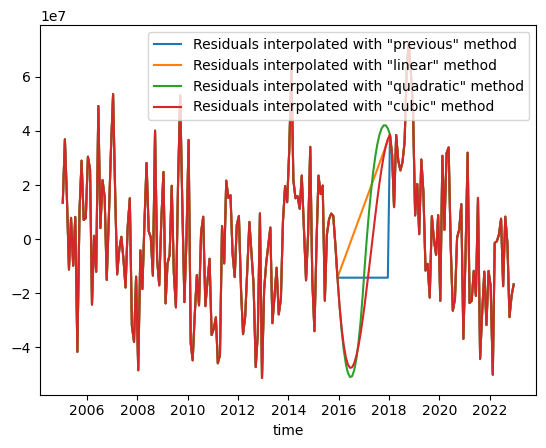

In [42]:
# Résidus uniquement, interpolés avec plusieurs méthodes

clim.signal(coefficients=[],method='previous').plot(label='Residuals interpolated with "previous" method')
clim.signal(coefficients=[],method='linear').plot(label='Residuals interpolated with "linear" method')
clim.signal(coefficients=[],method='quadratic').plot(label='Residuals interpolated with "quadratic" method')
clim.signal(coefficients=[],method='cubic').plot(label='Residuals interpolated with "cubic" method')

plt.legend()

# Climatologie sur une grille

Avec plusieurs dimensions, le principe est exactement le même. Le calcul est distribué pour chaque point de la grille, et on obtient une grille de coefficients. L'utilisation du paramètre *chunk* permet de découper le dataset afin d'optimiser la distribution de calculs par dask.  
L'exemple suivant montre comment tracer la tendance d'ohc

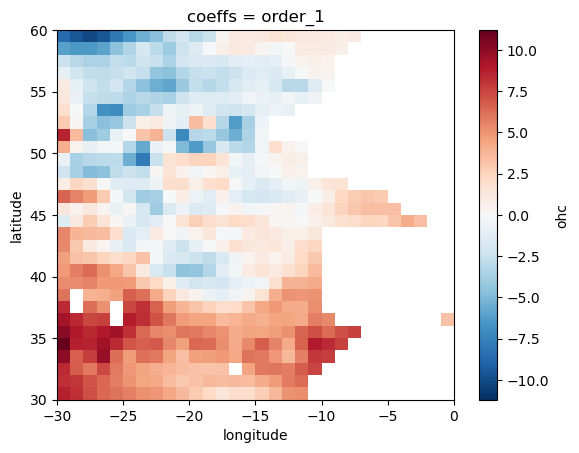

In [13]:
clim=moheacan.lntime.Climato(order=1)
clim.solve('ohc',chunk=dict(latitude=10,longitude=10))
clim.result.sel(coeffs='order_1').plot()

# Climatologie sur des points irréguliers

Le dataset exemple est le contenu en chaleur de l'océan entre 0 et 680m de profondeur, dans l'Atlantique Nord, entre -20 et -10 degrés de longitude et 40 et 50 degrés de latitude  
Les mesures sont faites entre 2004 et 2024, chaque mesure étant caractérisée par sa date, sa position, et le contenu en chaleur.  
On voit clairement un gradiant en fonction de la latitude

<xarray.Dataset> Size: 260kB
Dimensions:    (N_PROF: 8124)
Dimensions without coordinates: N_PROF
Data variables:
    latitude   (N_PROF) float64 65kB ...
    longitude  (N_PROF) float64 65kB ...
    time       (N_PROF) datetime64[ns] 65kB ...
    ohc        (N_PROF) float64 65kB 3.301e+10 3.092e+10 ... 3.439e+10 3.549e+10

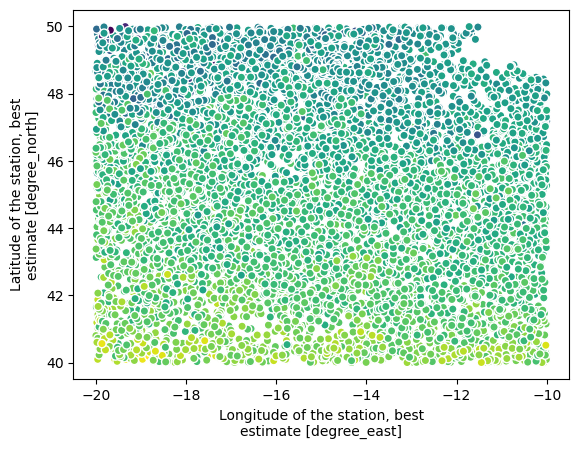

In [14]:
argo=xr.open_dataset('../../data/argo.nc')
argo.plot.scatter(x='longitude',y='latitude',c=argo.ohc)
argo

Pour faire une climatologie de la chaleur dans cette zone, il faut spécifier la dimension selon laquelle faire les calculs (*N_PROF*) et le nom de la variable contenant la date (*time*)

In [15]:
clim=argo.lntime.Climato(dim='N_PROF',var='time')
clim.solve('ohc')

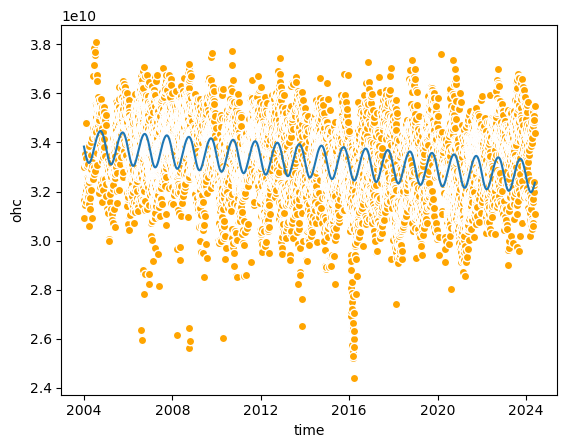

In [16]:
plt.plot(argo.time,clim.climatology())
argo.plot.scatter(x='time',y='ohc',c='orange')

Cette climatologie ne tient pas compte du gradiant en latitude, on a des mesures très dispersées et de grands résidus

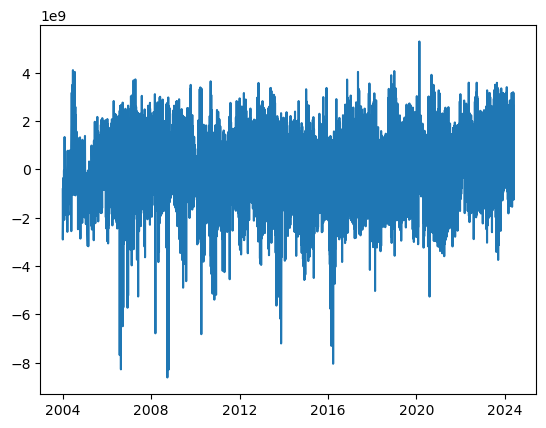

In [17]:
plt.plot(argo.time,clim.residuals())

On peut effectuer une régression sur l'écart en latitude et en longitude par rapport au centre de la zone

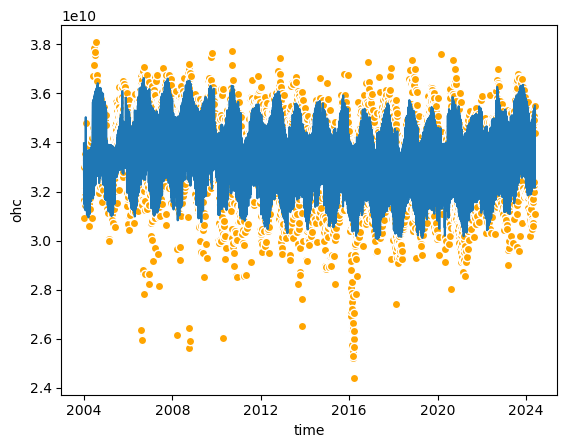

In [18]:
def f(X):
    return X

clim2=argo.lntime.Climato(dim='N_PROF',var='time',order=3)
clim2.add_coeffs('GradLat',f,'latitude',ref=45,scale=1.)
clim2.add_coeffs('GradLon',f,'longitude',ref=-15,scale=1.)
clim2.solve('ohc')

plt.plot(argo.time,clim2.climatology())
argo.plot.scatter(x='time',y='ohc',c='orange')

On voit que la climato intégrant le gradiant en position reflète plus la réalité, et les résidus sont plus petits

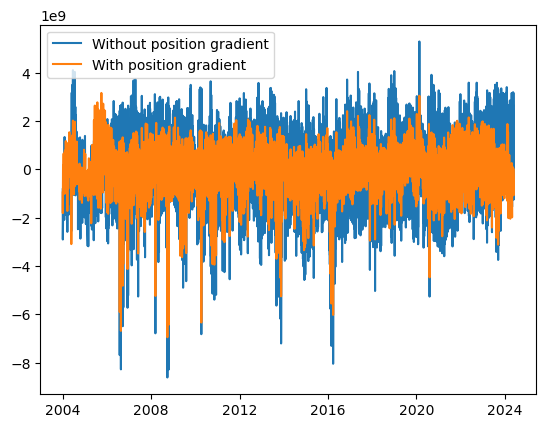

In [19]:
plt.plot(argo.time,clim.residuals(),label='Without position gradient')
plt.plot(argo.time,clim2.residuals(),label='With position gradient')
plt.legend()

Les résidus aont beaucoup plus proches d'un bruit blanc

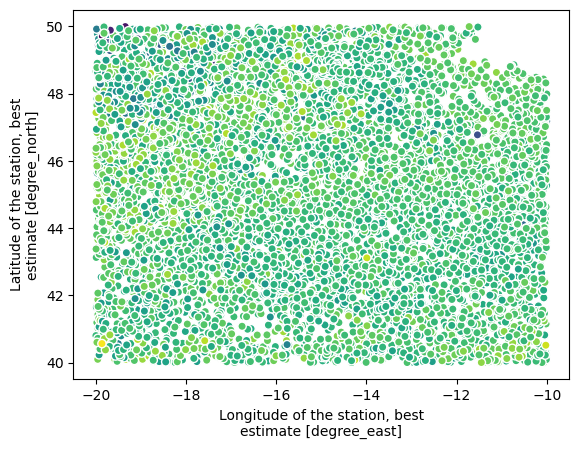

In [20]:
argo.plot.scatter(x='longitude',y='latitude',c=clim2.residuals())

On peut aussi, pour calculer la climato en un point, ajouter du poids en fonction de la distance de la mesure à ce point

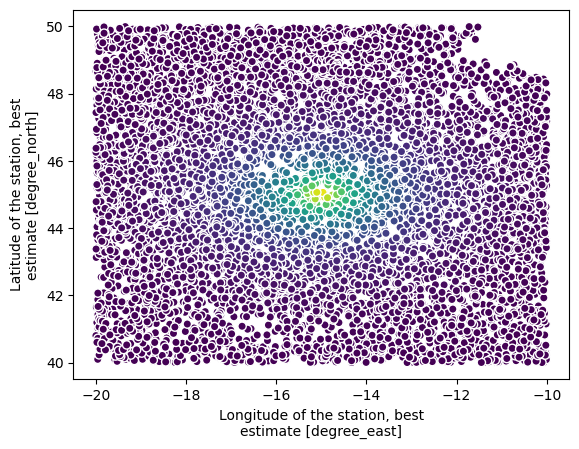

In [21]:
# Calcul de la fonction de poids et tracé du poids pour tous les points de mesure
sig_dist=100000.
centre=xr.DataArray(data=0,dims=['latitude','longitude'],coords=dict(latitude=[45],longitude=[-15]))
dist=centre.lngeo.distance(argo).squeeze().drop_vars(['latitude','longitude'])
poids=np.exp(-(dist/sig_dist))
argo['poids']=poids/poids.sum('N_PROF')
arg=argo.sortby(poids)
argo.plot.scatter(x='longitude',y='latitude',c=poids)

On résoud la climatologie an appliquant la fonction de poids à chaque mesure, et on calcule le signal climatologique sur une série temporelle régulière. A noter qu'il faut passer à la méthode *climatology* un dataset contenant toutes les coordonnées utiles pour le calcul des fonctions à fitter, c'est à dire *time*, *latitude*, et *longitude*

<xarray.Dataset> Size: 6kB
Dimensions:    (time: 241)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2024-01-01
Data variables:
    latitude   (time) float64 2kB 45.0 45.0 45.0 45.0 ... 45.0 45.0 45.0 45.0
    longitude  (time) float64 2kB -15.0 -15.0 -15.0 -15.0 ... -15.0 -15.0 -15.0

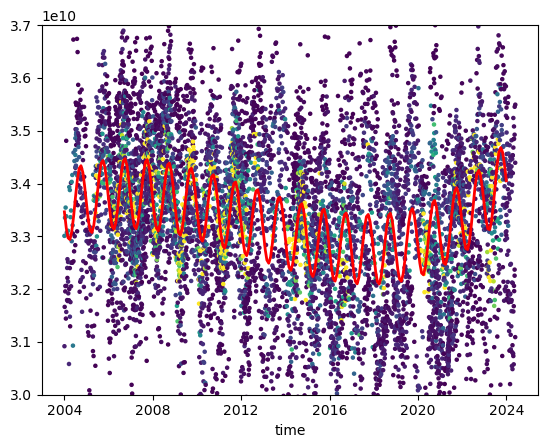

In [22]:
clim2.solve('ohc',poids=poids)

plt.scatter(x=argo.time,y=argo.ohc,c=argo.poids,s=5,vmax=0.0005)

t=xr.Dataset(coords=dict(time=pd.date_range('2004','2024',freq='1MS')))
z=xr.zeros_like(t.time.astype(float))
t_new=xr.Dataset(dict(latitude=z+45,longitude=z-15))
clim2.climatology(x=t_new,coefficients=['order_0','order_1','order_2','order_3','cosAnnual','sinAnnual']).plot(lw=2,c='r')
plt.ylim([3e10,3.7e10])
t_new


# Utilisation des coefficients de la climatologie indépendamment du signal d'origine
Si par exemple on a sauvegardé l'attribut "result" de l'instance Climato, on peut vouloir recréer un signal après avoir rechargé ces coefficients. C'est pour cela que "result" a un attribut "functions" contenant toutes les informations nécessaires pour regénérer un signal :
- le nom de la fonction 
- la référence et la mise à l'échelle
- le nom des coefficients
- le nom des variables pour la fonction
- des paramètres supplémentaires éventuels à passer à la fonction (par exemple, l'ordre pour le polynome à régresser)  
Il faut importer la classe *Generate_climato* depuis *lenapy.utils.climato*, l'initialiser avec les coefficients, ajouter éventuellement des fonctions de régressions s'il y en a d'autres que les cycles annuel et semi-annuel et un polynome, puis appeler *climatoligy* exactement comme avec l'instance Climato

In [23]:
from lenapy.utils.climato import Generate_climato
a=Generate_climato(clim2.result)
clim2.result.functions

[['annual',
  <xarray.DataArray 'time' ()> Size: 8B
  array('2004-01-01T04:25:01.344527773', dtype='datetime64[ns]'),
  numpy.timedelta64(86400000000000,'ns'),
  ['cosAnnual', 'sinAnnual'],
  ('time',),
  {}],
 ['semiannual',
  <xarray.DataArray 'time' ()> Size: 8B
  array('2004-01-01T04:25:01.344527773', dtype='datetime64[ns]'),
  numpy.timedelta64(86400000000000,'ns'),
  ['cosSemiAnnual', 'sinSemiAnnual'],
  ('time',),
  {}],
 ['pol',
  <xarray.DataArray 'time' ()> Size: 8B
  array('2004-01-01T04:25:01.344527773', dtype='datetime64[ns]'),
  numpy.timedelta64(86400000000000,'ns'),
  ['order_0', 'order_1', 'order_2', 'order_3'],
  ('time',),
  {'order': 3}],
 ['f', 45, 1.0, 'GradLat', ('latitude',), {}],
 ['f', -15, 1.0, 'GradLon', ('longitude',), {}]]

In [24]:
a.add_function(f)

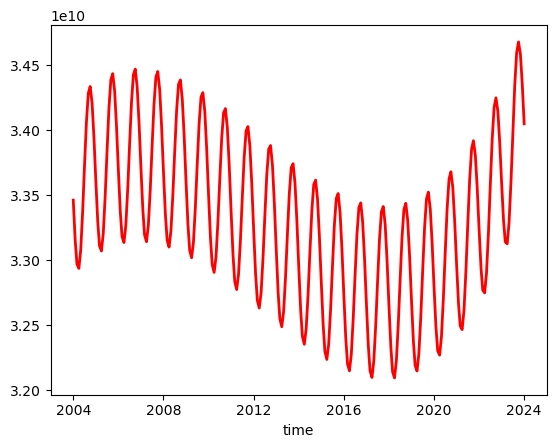

In [25]:
a.climatology(x=t_new,coefficients=['order_0','order_1','order_2','order_3','cosAnnual','sinAnnual']).plot(lw=2,c='r')
